## 0. Install and Import Dependencies

In [1]:
import os # File Helper
import numpy as np # Linear Algebra
import cv2 # Image processing
import tensorflow as tf # Model Creation
from typing import List # Type Annotations
from matplotlib import pyplot as plt # Visualizations
import imageio # Numpy to Gif

In [2]:
print(tf.__version__)

2.10.0


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    ...

In [4]:
import gdown

In [5]:
#url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
#output = 'data.zip'
#gdown.download(url, output, quiet=False)
#gdown.extractall(output)

In [6]:
def load_video(path:str) -> List[float]:
    
    capture = cv2.VideoCapture(path) # OpenCV object that handles the video at the given path
    frames = [] # To store each frame from the video
    for _ in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))): # Capture.get() is getting whatever property you pass in CAP_PROP_FRAME_COUNT is just the frame count
        ret, frame = capture.read() # ret is a boolean if available, frame is the frame array
        frame = tf.image.rgb_to_grayscale(frame) # Turns Colored Video into Grayscale (Black to Gray 0-1)
        frames.append(frame[190:236, 80:220, :]) # Storing frame into the frames list but indexed so it's only the mouth from the dataset examples
    capture.release() # Stops capturing video
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    with tf.device('/CPU:0'):
        return tf.cast((frames-mean), tf.float32) / std # Standardize the training example, (dataset-datasetmean)/datasetstd

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "] # Every character that could be in the training examples

In [8]:
# Tokenize Vocabulary
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is {char_to_num.get_vocabulary()} "
      f"size = {char_to_num.vocabulary_size()}")

The vocabulary is ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] size = 40


In [9]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        word = line.split()[-1]
        if word != "sil":
            tokens = [*tokens,' ', word]
    
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [10]:
def load_data(path):
    path = bytes.decode(path.numpy(), 'utf-8')
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [11]:
test_path = ".\\data\\s1\\bbaf2n.mpg"

In [12]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\s1\\bbaf2n.mpg'>

In [13]:
examples, labels = load_data(tf.convert_to_tensor(test_path))

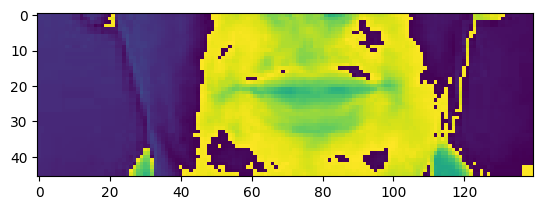

In [14]:
plt.imshow(examples[40])

In [15]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(labels.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [16]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## 2. Create Data Pipeline

In [42]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg') # Pull all .mpg files
data = data.shuffle(500, reshuffle_each_iteration=False) # Randomly shuffle them
data = data.map(mappable_function) # loads frames and labels for each training example
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40])) # 2 videos with 2 labels, ensuring we have 75 frames for each video and 40 tokens for labels
data = data.prefetch(tf.data.AUTOTUNE) # Preloading as training

train = data.take(450)
test = data.skip(450)

In [43]:
quick_test = data.as_numpy_iterator()
val = quick_test.next(); val[0]

array([[[[[1.38044   ],
          [1.38044   ],
          [1.4550583 ],
          ...,
          [0.2611643 ],
          [0.22385512],
          [0.22385512]],

         [[1.38044   ],
          [1.38044   ],
          [1.4550583 ],
          ...,
          [0.2611643 ],
          [0.22385512],
          [0.22385512]],

         [[1.38044   ],
          [1.38044   ],
          [1.3431308 ],
          ...,
          [0.3357827 ],
          [0.2984735 ],
          [0.2984735 ]],

         ...,

         [[0.9700389 ],
          [0.9700389 ],
          [0.9700389 ],
          ...,
          [0.07461838],
          [0.07461838],
          [0.07461838]],

         [[0.9700389 ],
          [0.9700389 ],
          [0.9700389 ],
          ...,
          [0.03730919],
          [0.03730919],
          [0.03730919]],

         [[0.9700389 ],
          [0.9700389 ],
          [0.9700389 ],
          ...,
          [0.03730919],
          [0.03730919],
          [0.03730919]]],


        [[[1.3058

In [19]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 10.062883377075195]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.062883377075195]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.062883377075195]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.062883377075195]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.062883377075195]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.062883377075195]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.062883377075195]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

![SegmentLocal](animation.gif "Gif")

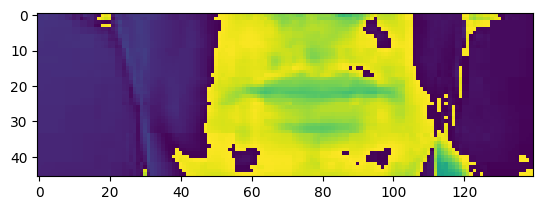

In [20]:
# 0:videos, 0: 1st video out of batched data, 0: first frame from video
# First Frame from first video
plt.imshow(val[0][0][0])

In [21]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in l four please'>

![SegmentLocal](animation.gif "Gif")

## 3. Design the Deep Neural Network

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard

In [23]:
model = Sequential(
    [
        Conv3D(128, 3, input_shape=train.as_numpy_iterator().next()[0][0].shape, padding='same', activation="relu", name="Conv_Layer_1"),
        MaxPool3D((1, 2, 2)),
        
        Conv3D(256, 3, padding='same', activation='relu', name="Conv_Layer_2"),
        MaxPool3D((1, 2, 2)),
        
        Conv3D(75, 3, padding='same', activation="relu", name="Conv_Layer_3"),
        MaxPool3D((1, 2, 2)),
        
        TimeDistributed(Flatten()),
        
        Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
        Dropout(.5),
        
        Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
        Dropout(.5),
        
        Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax')
        
    ]
)


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_Layer_1 (Conv3D)       (None, 75, 46, 140, 128)  3584      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 Conv_Layer_2 (Conv3D)       (None, 75, 23, 70, 256)   884992    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                             
                                                                 
 Conv_Layer_3 (Conv3D)       (None, 75, 11, 35, 75)    518475    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 75, 5, 17, 75)    0

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


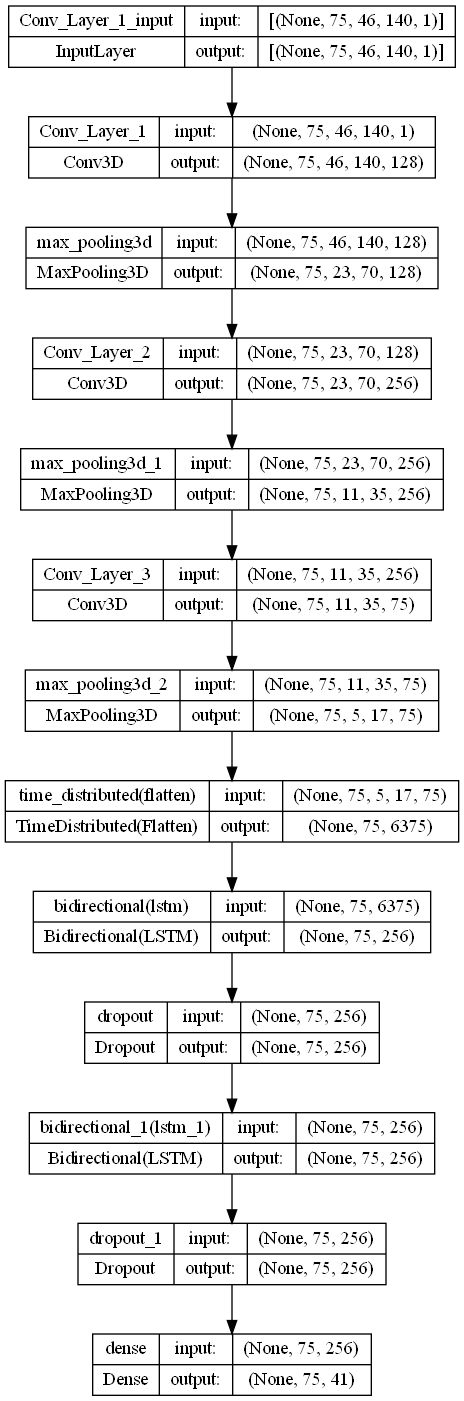

In [31]:
from datetime import datetime
import tensorboard

%load_ext tensorboard
from keras.utils.vis_utils import plot_model
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [32]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [35]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'fpyyyyyyyyyyyyyyyyyyyyfffffffffffffffffffffffffffffffffffffffffffffffffccbb'>

In [36]:
def scheduler(epoch, lr): # Changes learning rate based on epoch count exponentially
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [37]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length *= tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length *= tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [39]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
        
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat=self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)
            

In [40]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [41]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(data)

In [50]:
model.load_weights("models/checkpoint")
model.fit(train, validation_data=test, epochs=2, callbacks=[checkpoint_callback, schedule_callback, example_callback, tensorboard_callback])
model.save("model.h5")

Epoch 1/2
1/1 [==============================] - 0s 231ms/step loss: 5.76
Original: place red at sp p six please
Prediction: place red at p six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue in i zero now
Prediction: place blue in i zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 778s 2s/step - loss: 5.7601 - val_loss: 3.1056 - lr: 1.0000e-04
Epoch 2/2
1/1 [==============================] - 0s 234ms/step loss: 5.34
Original: set sp blue with b three soon
Prediction: set blue with b thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green at a nine again
Prediction: bin gren at a nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] -

In [51]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 46416), started 19:49:04 ago. (Use '!kill 46416' to kill it.)